In [1]:
#Librerías a usar
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima, ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings

### Importación de datos

In [2]:
#Leemos y visualizamos los datos:
df = pd.read_csv("ParisIndex-2016-2023.csv",index_col=0)
df

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-09-18,2023-09-19,2023-09-20,2023-09-21,2023-09-22,2023-09-25,2023-09-26,2023-09-27,2023-09-28,2023-09-29
Close,4522.450195,4537.629883,4480.470215,4403.580078,4333.759766,4312.740234,4378.75,4391.939941,4312.890137,4210.160156,...,7276.140137,7282.120117,7330.790039,7213.899902,7184.819824,7123.879883,7074.02002,7071.790039,7116.240234,7135.060059


In [3]:
#Primero transformamos el dataframe a un formato más cómodo en el que los índices de los valores son las fechas
df = df.T
#Posteriormente transformamos los índices a formato 'date-time' ya que originalmente son de tipo 'Object'
df.index = pd.to_datetime(df.index)
#vemos como quedó nuestro dataframe
df.head(5)

,Close
2016-01-04,4522.450195
2016-01-05,4537.629883
2016-01-06,4480.470215
2016-01-07,4403.580078
2016-01-08,4333.759766


### Visualización

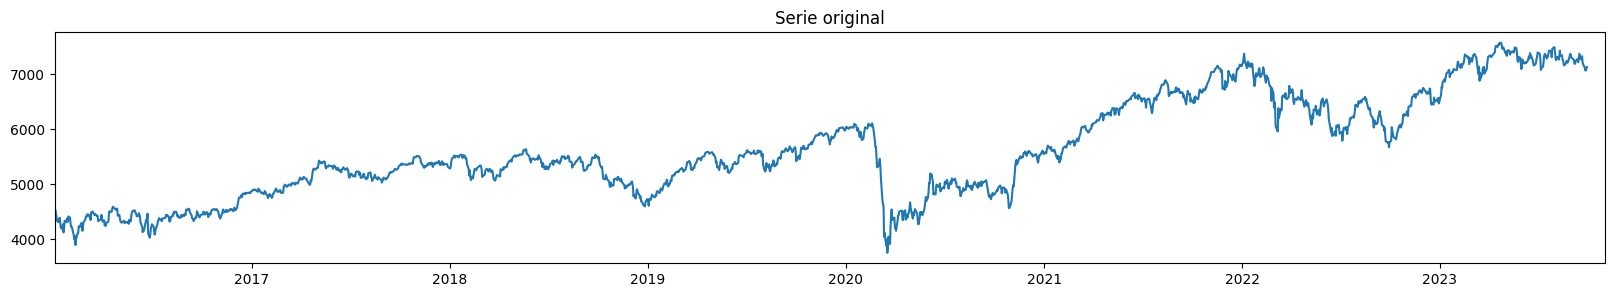

In [4]:
plt.figure(figsize=(20,3))
plt.plot(df)
plt.title("Serie original")
plt.xlim(min(df.index),pd.to_datetime("2023-11-01")) #Decorativo, para que no se vea un espacio en blanco al final
plt.show()

### Datos de entrenamiento y prueba

In [43]:
# Dividimos la serie de tiempo en datos de entrenamiento (train) y de prueba (test)
# También lo hacemos para la serie con logaritmo natural
df_train=df.iloc[:1589] #primeros 1589 datos
df_test=df.iloc[1589:] #del dato 1589 hasta el último
df_train_log=np.log(df.iloc[:1589])
df_test_log=np.log(df.iloc[1589:])

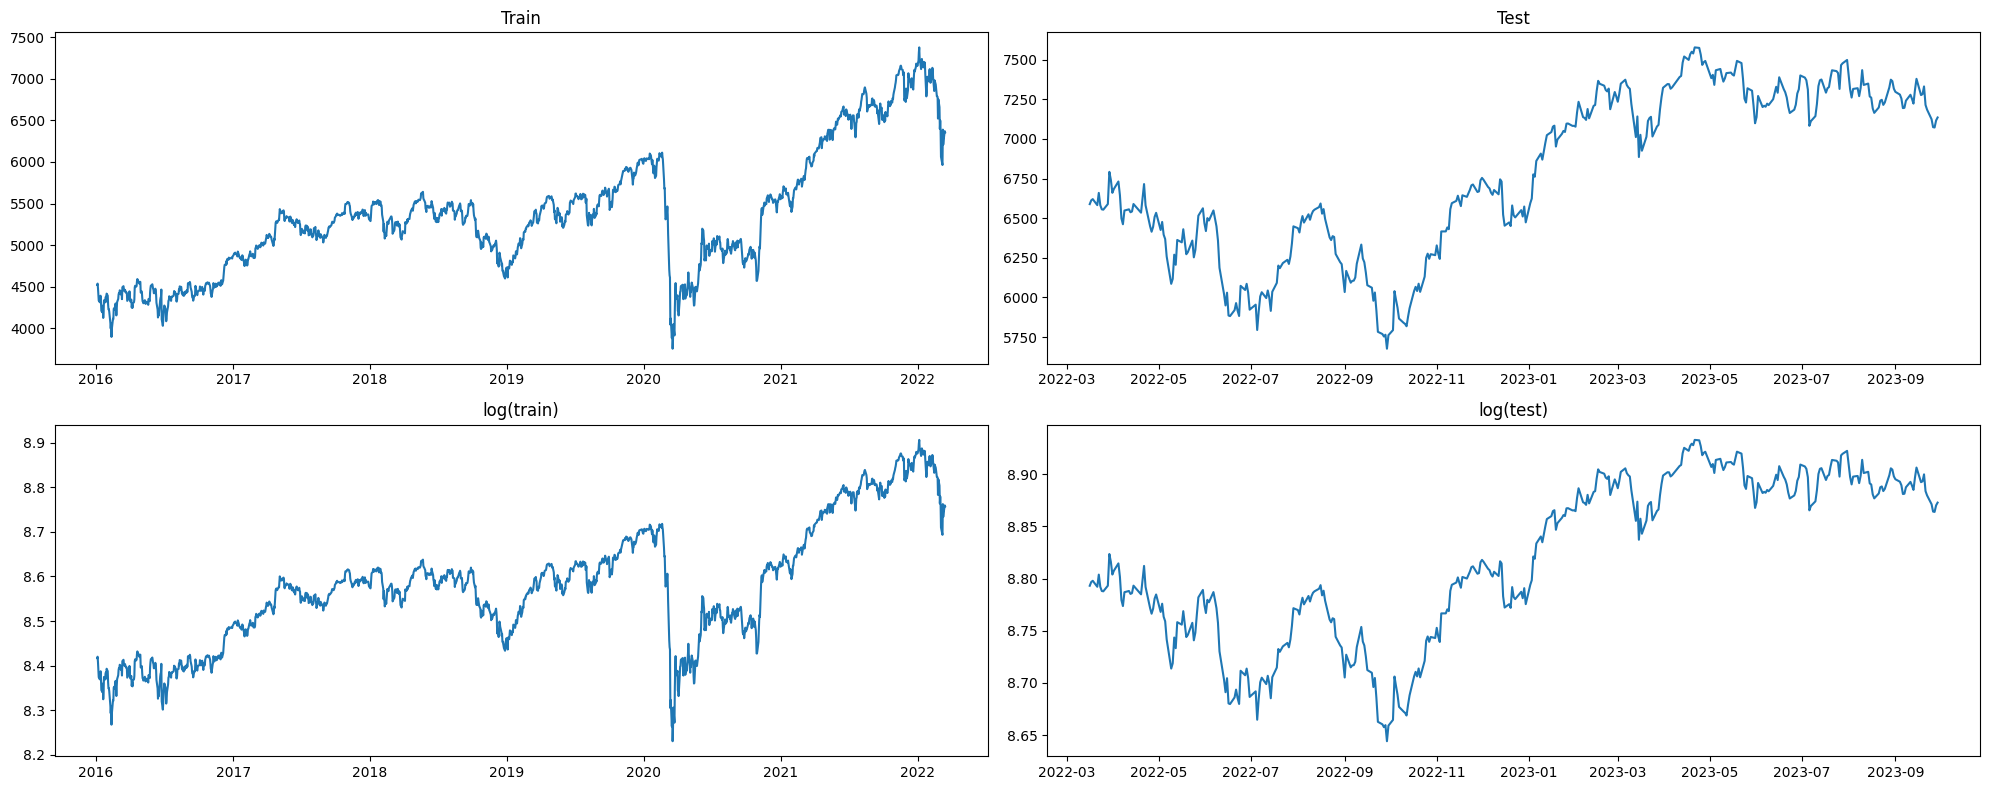

In [44]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(df_train)
plt.title("Train")

plt.subplot(2,2,2)
plt.plot(df_test)
plt.title("Test")

plt.subplot(2,2,3)
plt.plot(df_train_log)
plt.title("log(train)")

plt.subplot(2,2,4)
plt.plot(df_test_log)
plt.title("log(test)")
plt.tight_layout()
plt.show()

#### Diferencias de orden 1 y 2

In [8]:
#Aplicando diferencias de orden 1 a las series para intentar estabilizar la media
df_train_diff = df_train.diff().dropna()
df_train_diff_log = df_train_log.diff().dropna()

Adfuller diff(1) p-value = 1.0918185383244846e-15
Adfuller log(diff(1)) p-value = 7.293617040887867e-16

Adfuller diff(2) p-value = 1.0918185383244846e-15
Adfuller log(diff(2)) p-value = 7.293617040887867e-16


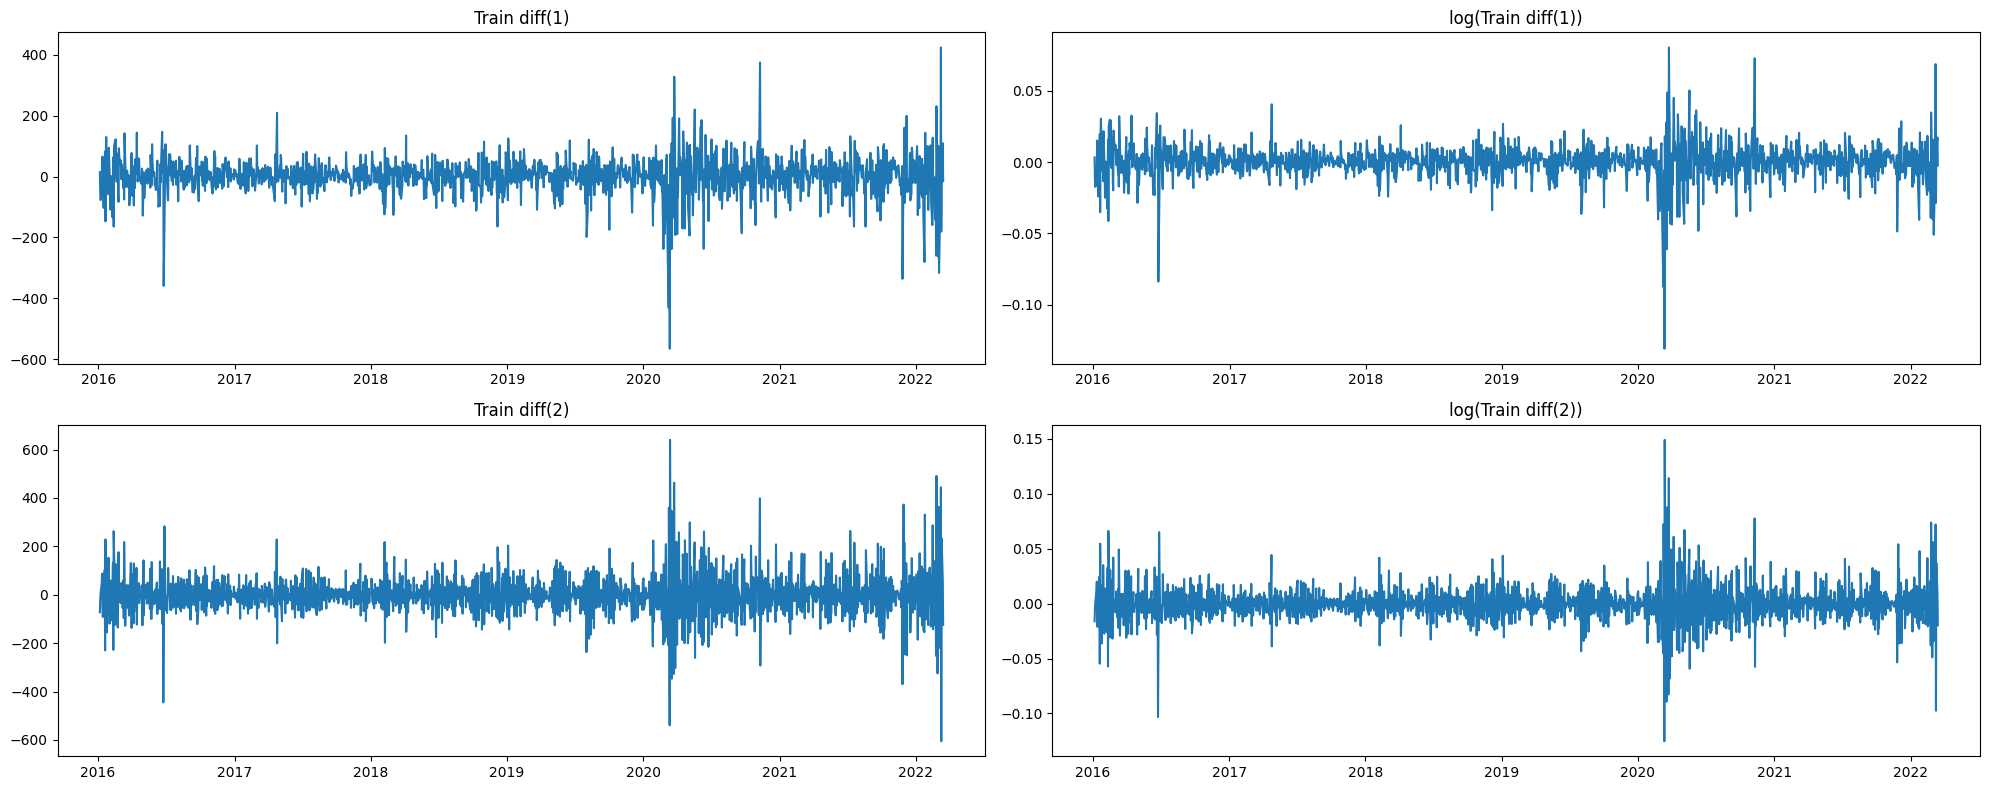

In [26]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(df_train_diff)
plt.title("Train diff(1)")

print(f"Adfuller diff(1) p-value = {adfuller(df_train_diff)[1]}")

plt.subplot(2,2,2)
plt.plot(df_train_diff_log)
plt.title("log(Train diff(1))")

print(f"Adfuller log(diff(1)) p-value = {adfuller(df_train_diff_log)[1]}")
print("")

plt.subplot(2,2,3)
plt.plot(df_train_diff.diff().dropna())
plt.title("Train diff(2)")

print(f"Adfuller diff(2) p-value = {adfuller(df_train_diff)[1]}")

plt.subplot(2,2,4)
plt.plot(df_train_diff_log.diff().dropna())
plt.title("log(Train diff(2))")

print(f"Adfuller log(diff(2)) p-value = {adfuller(df_train_diff_log)[1]}")
plt.tight_layout()
plt.show()

Vemos que no es necesario diferenciar la serie más de una vez, ya que no hay gran diferencia entre una u otra. Por lo tanto se infiere que el valor adecuado del valor de diferenciación es $d = 1$

#### ACF y PACF

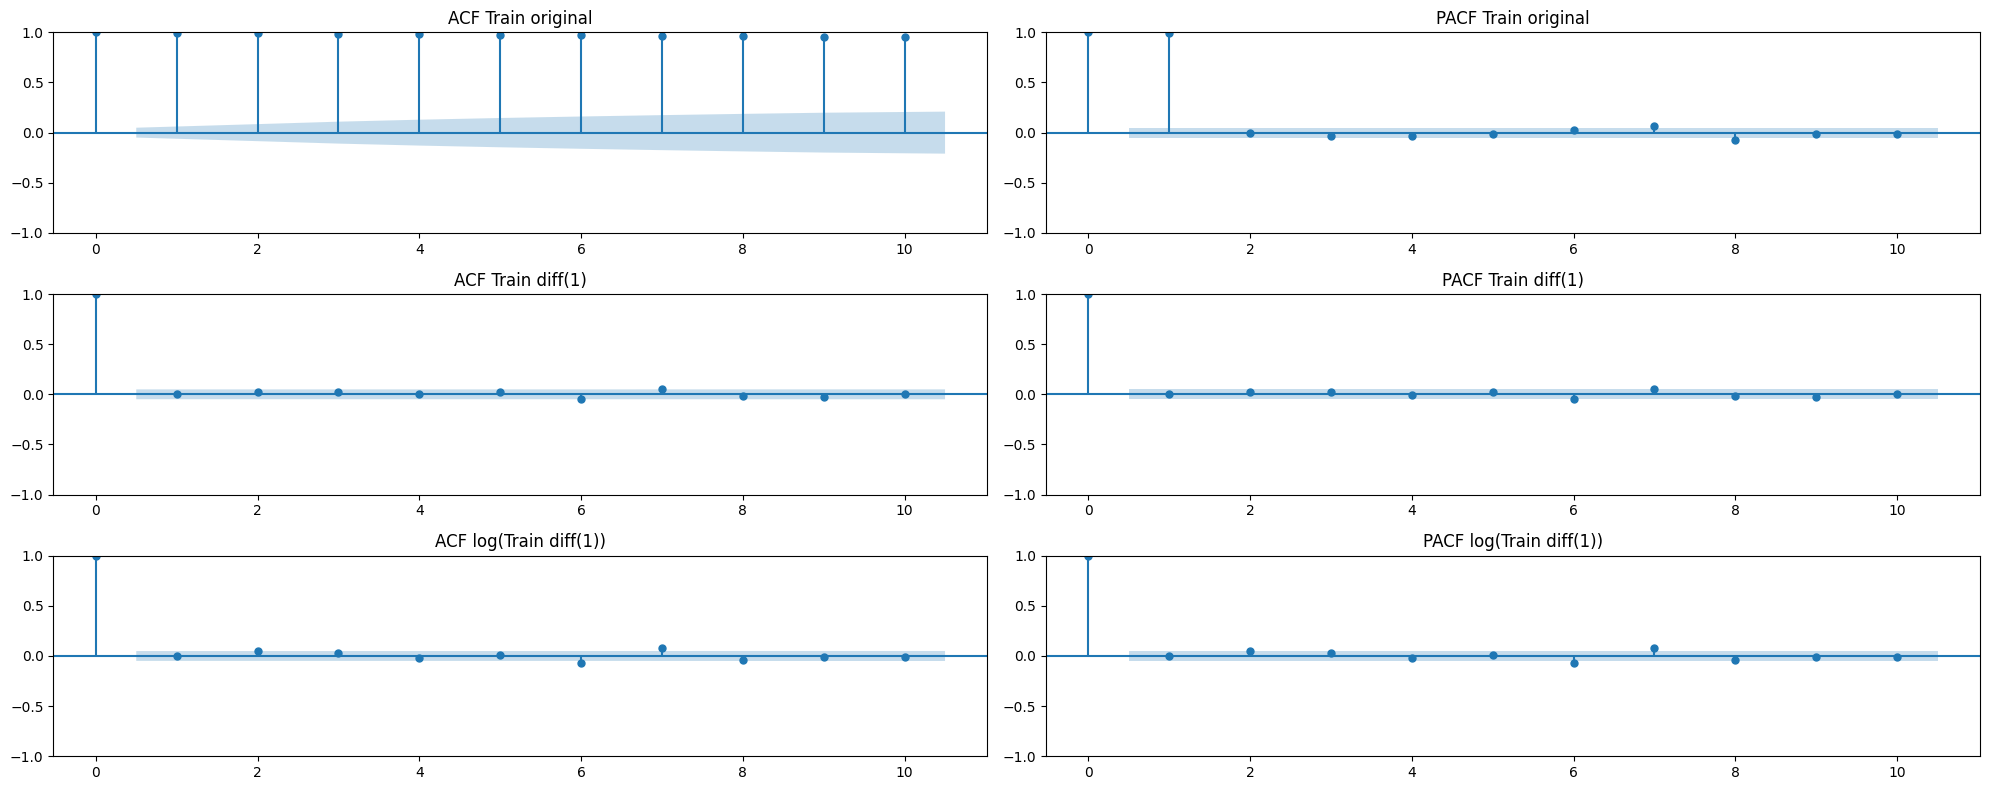

In [41]:
fig , ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3,2,figsize = (20,8))

plot_acf(df_train,lags = 10, ax=ax1)
plot_pacf(df_train_log, lags=10, ax=ax2)
plot_acf(df_train_diff,lags=10,ax = ax3)
plot_pacf(df_train_diff, lags=10, ax=ax4)
plot_acf(df_train_diff_log,lags=10,ax = ax5)
plot_pacf(df_train_diff_log, lags=10, ax=ax6)

ax1.set_title("ACF Train original")
ax2.set_title("PACF Train original")
ax3.set_title("ACF Train diff(1)")
ax4.set_title("PACF Train diff(1)")
ax5.set_title("ACF log(Train diff(1))")
ax6.set_title("PACF log(Train diff(1))")

plt.tight_layout()
plt.show()

Se puede estimar el parámetro p como el último lag fuera del intervalo de confianza en la PACF, tanto como en el caso de los datos con primera diferencia con los de primera diferencia con logaritmo parece adecuado $p=0$ y analizando la ACF para estimar q se tiene lo mismo. Entonces parece ser que el modelo adecuado es un ARIMA(0,1,0) o bien un I(1), que es equivlente a que los datos corresponden con una caminata aleatoria y estacionaria (esto es porque estamos suponiendo que la serie se volvió estacionaria solo con la diferenciación de primer orden ...)

## Modelos ARIMA

### Parámetros manuales usando la función ARIMA

In [101]:
#warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model_manual = ARIMA(order=(0,1,0))
model_manual.fit(y = df_train) #Ajusta los mejores coeficientes a los datos de entrenamiento con el modelo ARIMA(0,1,0)
model_manual.summary()

/home/agustin/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/agustin/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1589
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8818.413
Date:                Wed, 01 Nov 2023   AIC                          17640.826
Time:                        23:48:06   BIC                          17651.566
Sample:                             0   HQIC                         17644.815
                               - 1589                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1540      1.621      0.712      0.477      -2.023       4.331
sigma2      3898.8474     56.539     68.959      0.000    3788.033    4009.662
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7972.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

De la tabla de resumen anterior vemos que todas las metricas relacionadas con la bondad del ajuste son muy altas, lo que dice que no hay un ajuste muy bueno entre el modelo y los datos

/home/agustin/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/agustin/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


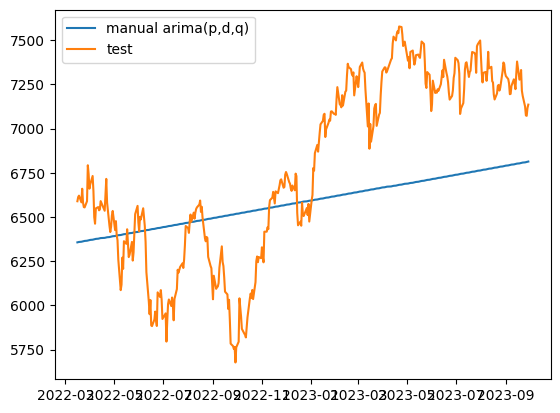

In [104]:
forecast_manual = model_manual.predict(df_test.shape[0]) #predice el número de observaciones que tiene el conjunto de test
forecast_manual.index = df_test.index
plt.plot(forecast_manual,label = "manual arima(p,d,q)")
plt.plot(df_test,label="test")
plt.legend()
plt.show()

### Parámetros automáticos usando auto_arima

In [114]:
model_auto = auto_arima(df_train,start_p=0,max_p=2,start_q=0,max_q=2,start_P=0,max_P=2,start_Q=0,max_Q=2)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1589
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8818.684
Date:                Wed, 01 Nov 2023   AIC                          17639.368
Time:                        23:59:23   BIC                          17644.738
Sample:                             0   HQIC                         17641.363
                               - 1589                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3900.1798     54.826     71.137      0.000    3792.723    4007.637
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7972.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.51   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/agustin/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/agustin/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


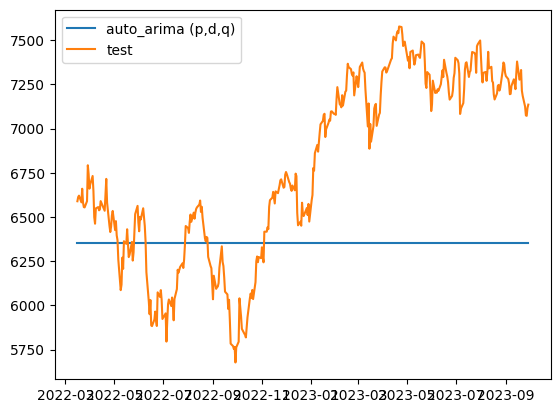

In [115]:
forecast_auto = model_auto.predict(df_test.shape[0])
forecast_auto.index = df_test.index
plt.plot(forecast_auto,label = "auto_arima (p,d,q)")
plt.plot(df_test,label = "test")
plt.legend()
plt.show()

### Comparación de los modelos

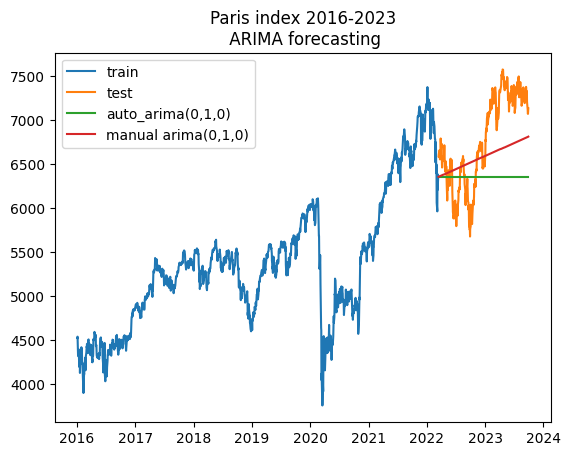

In [117]:
plt.plot(df_train,label = "train")
plt.plot(df_test,label="test")
plt.plot(forecast_auto,label = "auto_arima(0,1,0)")
plt.plot(forecast_manual,label = "manual arima(0,1,0)")
plt.title("Paris index 2016-2023\n ARIMA forecasting")
plt.legend()
plt.show()

Aunque el modelo usado para los dos casos (automático y manual) fue un ARIMA(0,1,0) o bien un I(1) se obtuvo una ligera mejor aproximación al usar la versión en la que se colocaron manualmente los parámetros. De cualquier forma es una primera aproximación de forecasting y el error es grande, por lo menos se refleja la tendecia global de aumento en los dos casos.